# Improved Training Of GAN

This notebook implements WGAN and DCGAN approaches for improved training of GANS

## 1. Setup

Start by importing the necessary libraries and setting up the environment.


In [1]:
# Import necessary libraries
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from data.cifar10_data import get_cifar10_data
from data.mnist_data import get_mnist_data, get_fashion_mnist_data
from model.dcgan import DCGAN
from model.wgan import WGAN
from torch.utils.tensorboard import SummaryWriter


%load_ext autoreload
%autoreload 2



## 2. Hyperparameters

Here, we define the hyperparameters for our experiments.


In [20]:
# Hyperparameters
gan_train_config= {
    'dcgan':{'nz': 128,
             'lr': 5e-4,
             'n_iter': 1500,
             'gan_type': 'dcgan'},
    
    'wgan': {'nz': 128,
             'lr': 5e-4,
             'n_critic': 5,
             'clamp_value': 0.01,
             'n_iter': 2000,
             'lambda_gp': 10,
             'gan_type': 'wgan'}}

dataset = 'fashion_mnist'  # mnist/fashion_mnist/cifar10
batch_size = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Reproduce results by seed:
seed = 205917883
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

Using device:  cuda


## 3. Dataset Handling


In [ ]:
# Get data loader
if dataset == 'cifar10':
    data_loader = get_cifar10_data(batch_size)
    channels = 3
elif dataset == 'mnist':
    data_loader = get_mnist_data(batch_size)
    channels = 1
elif dataset == 'fashion_mnist':
    data_loader = get_fashion_mnist_data(batch_size)
    channels = 1
else:
    raise ValueError("Invalid dataset")


## Training

In [53]:
# Function to plot generated samples
def plot_generated_samples(step, noise, gan):
    with torch.no_grad():
        fake_images = gan.generator(noise).detach().cpu()

    # Handle both grayscale and RGB images
    if fake_images.shape[1] == 1:
        fake_images = fake_images.repeat(1, 3, 1, 1)  # Convert grayscale to RGB for plotting

    grid = torchvision.utils.make_grid(fake_images, padding=2, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f'Generated Images at Step {step}')
    plt.axis('off')  # Hide axis
    plt.show()
    
    return grid

In [54]:
def train_gan(config, device, data_loader):
    gan_type = config['gan_type']
    nz = config['nz']
    lr = config['lr']
    n_iter = config['n_iter']
    channels = 1 if dataset in ['mnist', 'fashion_mnist'] else 3
    clamp_value = config.get('clamp_value', None)
    n_critic = config.get('n_critic', 1)
    writer = SummaryWriter()

    if gan_type == 'wgan':
        gan = WGAN(nz, lr, device, channels=channels, clamp_value=clamp_value, n_critic=n_critic)
    else:
        gan = DCGAN(nz, lr, device, channels=channels)

    fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)  # Fixed noise for consistent samples

    # Lists to store losses
    D_losses = []
    G_losses = []

    # Training loop
    data_iter = iter(data_loader)
    pbar = tqdm(range(n_iter))

    for step in pbar:
        if gan_type == 'wgan':
            for p in gan.discriminator.parameters():
                p.requires_grad = True

        for i in range(gan.n_critic if gan_type == 'wgan' else 1):
            try:
                real_data = next(data_iter)
            except StopIteration:
                # Start next epoch over data
                data_iter = iter(data_loader)
                real_data = next(data_iter)

            real_data = real_data[0].to(device)
            noise = torch.randn(real_data.shape[0], nz, 1, 1, device=device)
            fake_data = gan.generator(noise)

            D_loss = gan.train_discriminator(real_data, fake_data)
            D_losses.append(D_loss.item())

        if gan_type == 'wgan':
            for p in gan.discriminator.parameters():
                p.requires_grad = False

        G_loss = gan.train_generator(fake_data)
        G_losses.append(G_loss.item())

        # Log losses to TensorBoard
        writer.add_scalar('Loss/Discriminator', D_loss.item(), step)
        writer.add_scalar('Loss/Generator', G_loss.item(), step)

        # Update tqdm progress bar
        pbar.set_description(f"Step [{step}/{n_iter}] | D_loss: {D_loss.item():.3f} | G_loss: {G_loss.item():.3f}")

        # Plot generated samples
        if step % 500 == 0:
            grid = plot_generated_samples(step, fixed_noise, gan)
            writer.add_image(f'Generated Images at Step {step}', grid, step)

    # Close TensorBoard writer
    writer.close()

    # Save the models
    save_path = './saved_models'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    torch.save(gan.generator.state_dict(), os.path.join(save_path, f'{gan_type}_generator.pth'))
    torch.save(gan.discriminator.state_dict(), os.path.join(save_path, f'{gan_type}_discriminator.pth'))

    return gan, D_losses, G_losses

In [18]:
def interpolate_losses(losses, target_length):
    # Used in WGAN with n_critic > 1, to interpolate losses for plotting
    x_original = np.linspace(0, 1, len(losses))
    x_target = np.linspace(0, 1, target_length)
    interpolated_losses = np.interp(x_target, x_original, losses)
    return interpolated_losses

def plot_loss_curves(D_losses, G_losses):
    # Determine the lesser length
    min_length = min(len(D_losses), len(G_losses))

    # Interpolate both losses to the lesser length
    D_losses = interpolate_losses(D_losses, min_length)
    G_losses = interpolate_losses(G_losses, min_length)
    
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.plot(D_losses, label='Discriminator Loss', color='blue', linewidth=0.5, alpha=0.6)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Discriminator Loss', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(G_losses, label='Generator Loss', color='green', linewidth=0.5, alpha=0.6)
    ax2.set_ylabel('Generator Loss', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

    plt.title('Training Losses')
    plt.tight_layout()
    plt.show()


### Train DCGAN

Step [0/1500] | D_loss: 1.568 | G_loss: 5.090:   0%|          | 0/1500 [00:00<?, ?it/s]

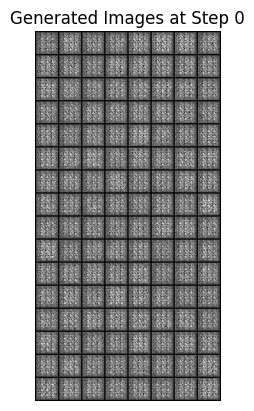

Step [500/1500] | D_loss: 0.881 | G_loss: 1.686:  33%|███▎      | 500/1500 [00:42<01:23, 12.01it/s]

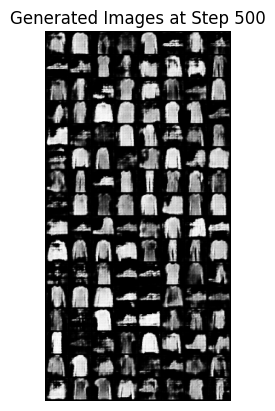

Step [1000/1500] | D_loss: 1.050 | G_loss: 0.806:  67%|██████▋   | 1000/1500 [01:25<00:42, 11.74it/s]

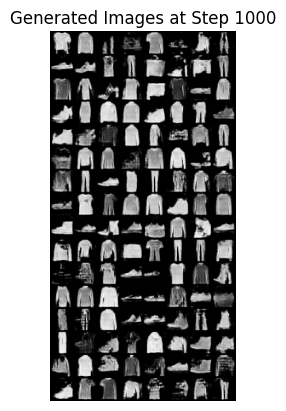

Step [1499/1500] | D_loss: 1.125 | G_loss: 3.882: 100%|██████████| 1500/1500 [02:08<00:00, 11.64it/s]


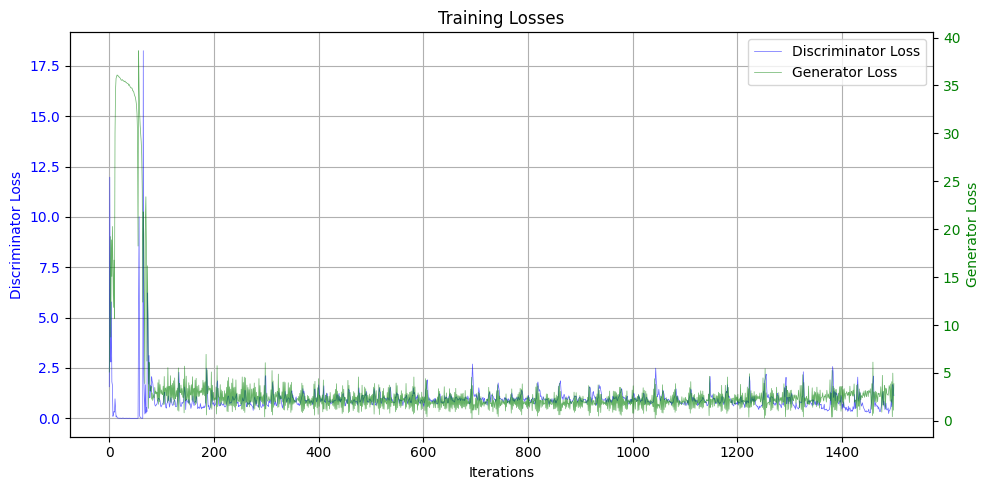

In [56]:
config = gan_train_config['dcgan']
gan, D_losses, G_losses = train_gan(config, device, data_loader)
plot_loss_curves(D_losses, G_losses)

### Train WGAN

Step [0/2000] | D_loss: -41.150 | G_loss: 43.610:   0%|          | 0/2000 [00:00<?, ?it/s]

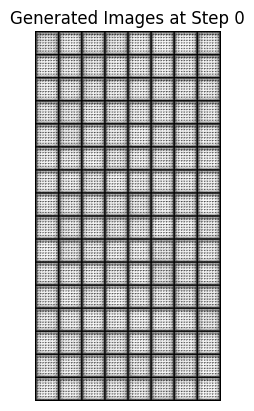

Step [500/2000] | D_loss: -3.595 | G_loss: 22.290:  25%|██▌       | 500/2000 [04:13<12:46,  1.96it/s] 

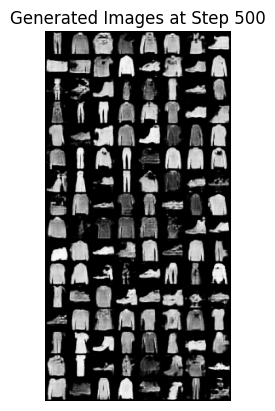

Step [1000/2000] | D_loss: -3.985 | G_loss: 20.853:  50%|█████     | 1000/2000 [08:29<08:27,  1.97it/s]

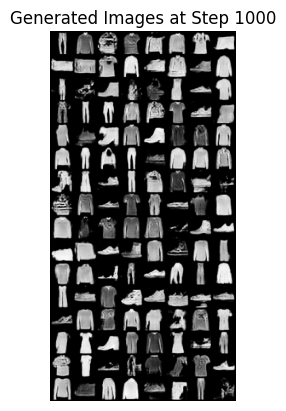

Step [1500/2000] | D_loss: -3.485 | G_loss: 16.358:  75%|███████▌  | 1500/2000 [12:46<04:16,  1.95it/s] 

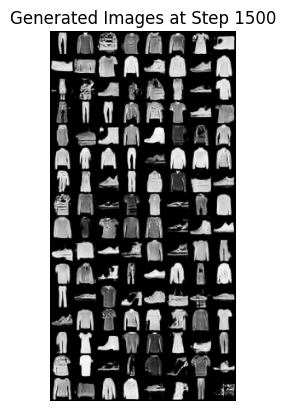

Step [1999/2000] | D_loss: -5.548 | G_loss: 14.368: 100%|██████████| 2000/2000 [17:02<00:00,  1.96it/s] 


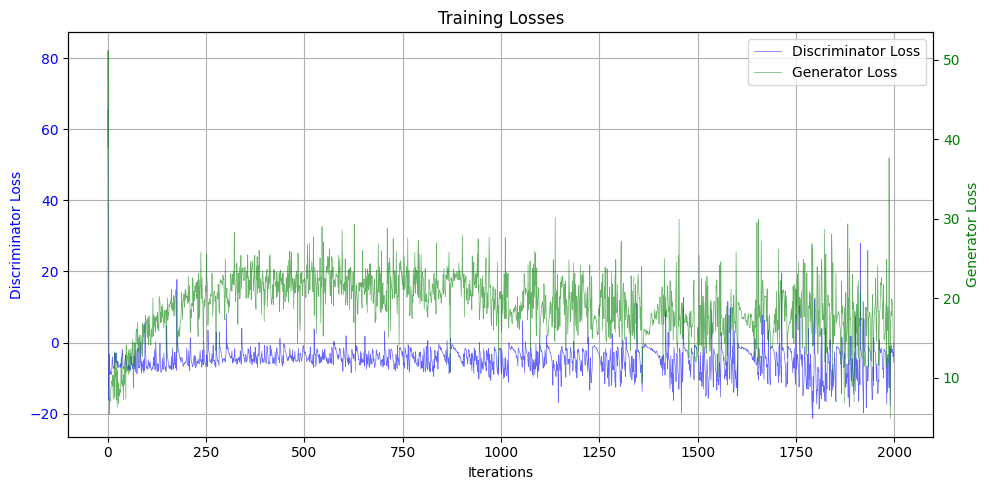

In [21]:
config = gan_train_config['wgan']
gan, D_losses, G_losses = train_gan(config, device, data_loader)
plot_loss_curves(D_losses, G_losses)

## Evaluation

In [22]:
# Load the saved model and plot fake samples
def load_and_plot_samples(generator_path, net_config, device, data_loader, num_samples=64, gan_type='dcgan'):
    nz = net_config['nz']
    lr = net_config['lr']
    if gan_type == 'wgan':
        gan = WGAN(nz, lr, device, channels=channels, clamp_value=clamp_value, n_critic=n_critic)
    else:
        gan = DCGAN(nz, lr, device, channels=channels)
    
    gan.generator.load_state_dict(torch.load(generator_path, map_location=device))
    gan.generator.eval()

    with torch.no_grad():
        noise = torch.randn(num_samples, nz, 1, 1, device=device)
        fake_images = gan.generator(noise).cpu()

    # Get real samples
    real_data = next(iter(data_loader))[0][:2]  # Get the first batch and take the first two samples

    # Create a figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(15, 5))

    # Plot Generated Images
    axes[0].imshow(torchvision.utils.make_grid(fake_images, padding=2, normalize=True).permute(1, 2, 0))
    axes[0].set_title('Generated Images')
    axes[0].axis('off')

    # Plot Real Images
    axes[1].imshow(torchvision.utils.make_grid(real_data, padding=2, normalize=True).permute(1, 2, 0))
    axes[1].set_title('Real Images')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


### Evaluate DCGAN

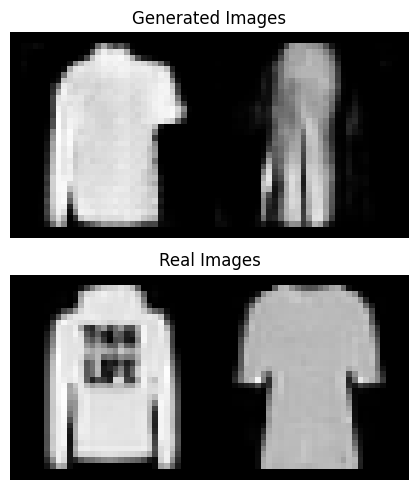

In [23]:
save_path = './saved_models'
generator_path = os.path.join(save_path, f'dcgan_generator.pth')
load_and_plot_samples(generator_path, gan_train_config['dcgan'], device, data_loader=data_loader,num_samples=2)

### Evaluate WGAN-GP

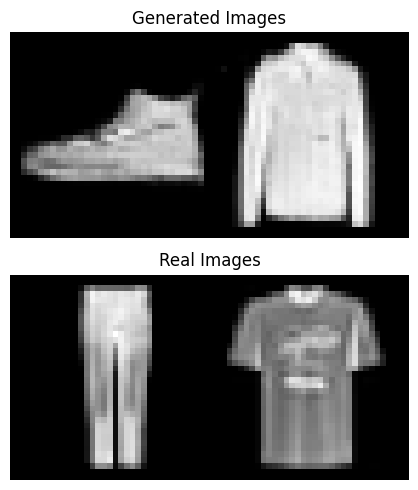

In [26]:
generator_path = os.path.join(save_path, f'wgan_generator.pth')
load_and_plot_samples(generator_path, gan_train_config['wgan'], device, data_loader=data_loader,num_samples=2)